In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pingouin import ancova

ModuleNotFoundError: No module named 'pingouin'

In [4]:
# def remove_outliers_iqr(df, cols):
#     # Calculate quantiles and IQR
#     Q1 = df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
#     Q3 = df[cols].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Return a boolean array of the rows with (any) non-outlier column values
#     condition = ~((df[cols] < (Q1 - 2 * IQR)) | (df[cols] > (Q3 + 2 * IQR))).any(axis=1)
    
#     # Filter our dataframe based on condition
#     print(df[~condition])
#     df = df[condition]
#     return df

def remove_outliers(df, cols):
    for col in cols:
        mean = df[col].mean()
        sd = df[col].std()
        upper = float(mean + sd*3)
        lower = float(mean - sd*3)
        condition = ~((df[col] > upper) | (df[col] < lower))
        df = df[condition]
    return df

#### Import data

In [5]:
# Import scores
aud_nb = pd.read_csv('auditory-2-back-scores.csv')
vs_nb = pd.read_csv('visuospatial-2-back-scores.csv')
speech_training = pd.read_csv('synthetic-speech-training-scores.csv')
speech_test = pd.read_csv('synthetic-speech-test-scores.csv')
len(np.unique(vs_nb['sub']))

128

In [6]:
# Check which subjects are missing
speech_test_pre = speech_test[speech_test.test == 'pre']
speech_test_post = speech_test[speech_test.test == 'post']
pre_subs = set(speech_test_pre['sub'])
post_subs = set(speech_test_post['sub'])
diff_pre = list(post_subs - pre_subs)
diff_post = list(pre_subs - post_subs)

# Drop those subs
for sub in diff_pre:
    print(f'Dropping sub {sub} for missing pre-test data')
    speech_test = speech_test[speech_test['sub'] != sub]
for sub in diff_post:
    print(f'Dropping sub {sub} for missing post-test data')
    speech_test = speech_test[speech_test['sub'] != sub]

# Sort df by sub
speech_test = speech_test.sort_values(by = 'sub')

Dropping sub 16 for missing post-test data
Dropping sub 44 for missing post-test data


#### Compute pre- and post-test score difference

In [7]:
# Pivot long to wide
speech_test_wide = speech_test[speech_test.test == 'pre']
speech_test_wide['post'] = list(speech_test[speech_test.test == 'post']['percent_correct'])
speech_test_wide['pre'] = list(speech_test[speech_test.test == 'pre']['percent_correct'])
speech_test_diff = speech_test_wide

# Compute pre- vs post-test score difference
speech_test_diff['diff'] = np.array(speech_test_diff['post']) - np.array(speech_test_diff['pre'])

# Remove outliers
speech_test = remove_outliers(speech_test, ['percent_correct'])
speech_test_diff = remove_outliers(speech_test_diff, ['diff'])

/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_1525/1451548983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_test_wide['post'] = list(speech_test[speech_test.test == 'post']['percent_correct'])
/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_1525/1451548983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_test_wide['pre'] = list(speech_test[speech_test.test == 'pre']['percent_correct'])
/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_1525/1451548983.p

#### Add NB score to data frames

In [8]:
# Drop missing subs from NB data
for sub in diff_pre + diff_post:
    print(f'Dropping sub {sub} for missing speech data')
    aud_nb = aud_nb[aud_nb['sub'] != sub]
    vs_nb = vs_nb[vs_nb['sub'] != sub]

# Find missing subs from NB data
speech_nb = speech_test_diff.copy()
speech_subs = set(np.unique(speech_nb['sub']))
aud_subs = set(np.unique(aud_nb['sub']))
vs_subs = set(np.unique(vs_nb['sub']))
missing_vs = list(speech_subs - vs_subs)
missing_aud = list(vs_subs - speech_subs)
missing = missing_vs + missing_aud
print(vs_subs - speech_subs)
print(aud_subs - speech_subs)
print(speech_subs - vs_subs)
print(speech_subs - aud_subs)

# Merge dataframes
speech_nb = speech_nb.merge(aud_nb, on = ['sub'], how = 'outer')
speech_nb = speech_nb.rename(columns={"d_prime": "d_prime_aud", "hit_rate": "hit_rate_aud", "fa_rate": "fa_rate_aud"})
speech_nb = speech_nb.merge(vs_nb, on = ['sub'], how = 'outer')
speech_nb = speech_nb.rename(columns={"d_prime": "d_prime_vs", "hit_rate": "hit_rate_vs", "fa_rate": "fa_rate_vs"})

# Drop missing subs from data
for sub in missing:
    print(f'Dropping sub {sub} for missing speech data')
    speech_nb = speech_nb[speech_nb['sub'] != sub]

# Remove outliers
speech_nb = remove_outliers(speech_nb, ['diff', 'hit_rate_aud', 'fa_rate_aud', 'd_prime_aud', 'hit_rate_vs', 'fa_rate_vs', 'd_prime_vs'])

# Save
speech_nb.to_csv("data.csv", index = False)
speech_nb

Dropping sub 16 for missing speech data
Dropping sub 44 for missing speech data
{2}
{2}
set()
set()
Dropping sub 2 for missing speech data


,sub,test,ID,feedback,percent_correct,post,pre,diff,hit_rate_aud,fa_rate_aud,d_prime_aud,hit_rate_vs,fa_rate_vs,d_prime_vs
0,1,pre,True,A,10.0,16.0,10.0,6.0,0.666667,0.133333,1.541499,0.800000,0.200000,1.683242
1,3,pre,True,A,16.0,21.0,16.0,5.0,0.800000,0.016667,2.969666,0.233333,0.200000,0.113708
2,4,pre,True,O,17.0,31.0,17.0,14.0,0.600000,0.100000,1.534899,0.533333,0.216667,0.867152
3,5,pre,True,A,5.0,8.0,5.0,3.0,0.833333,0.066667,2.468508,0.966667,0.066667,3.335001
4,6,pre,True,O,15.0,24.0,15.0,9.0,0.333333,0.166667,0.536694,0.600000,0.016667,2.381392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,144,pre,True,O,30.0,61.0,30.0,31.0,0.700000,0.066667,2.025486,0.566667,0.166667,1.135316
121,145,pre,True,A,28.0,29.0,28.0,1.0,0.866667,0.016667,3.238817,0.983333,0.083333,3.511039
122,180,pre,True,O,45.0,50.0,45.0,5.0,0.966667,0.008333,4.227894,0.983333,0.008333,4.522025
123,1105,pre,True,A,18.0,29.0,18.0,11.0,0.800000,0.300000,1.366022,0.833333,0.216667,1.750922


## 1. Starter plots

#### Pre- vs post-test scores

<AxesSubplot: xlabel='test', ylabel='percent_correct'>

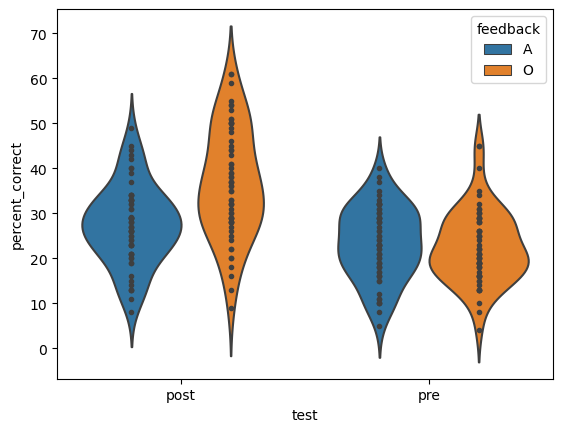

In [7]:
sns.violinplot(data=speech_test, x = "test", y = "percent_correct", hue = "feedback", inner = "point")

#### Learning by feedback

<AxesSubplot: xlabel='feedback', ylabel='diff'>

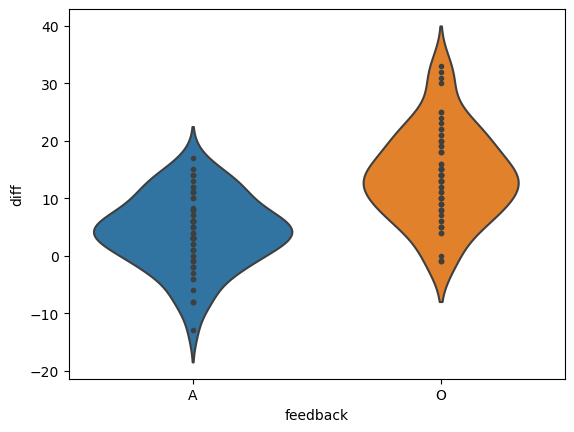

In [8]:
sns.violinplot(data=speech_test_diff, x = "feedback", y = "diff", inner = "point")

#### Correlation between pre-test scores and N-back scores

**fig 1. Auditory n-back and pretest scores**

                            OLS Regression Results                            
Dep. Variable:                    pre   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7.239
Date:                Mon, 06 Jan 2025   Prob (F-statistic):            0.00818
Time:                        10:19:07   Log-Likelihood:                -410.61
No. Observations:                 119   AIC:                             825.2
Df Residuals:                     117   BIC:                             830.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.0206      2.007      8.980      

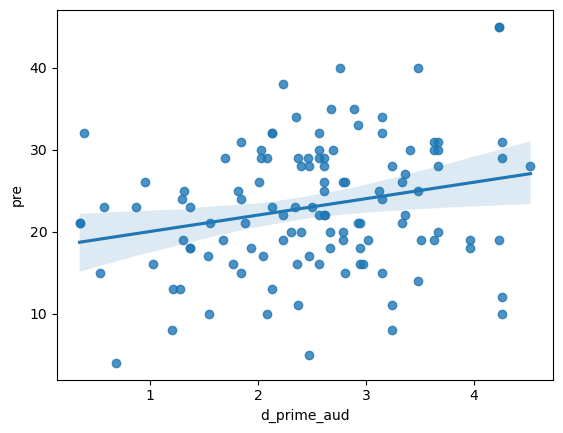

In [9]:
sns.regplot(data=speech_nb, x = "d_prime_aud", y = "pre")
y = speech_nb.pre
X = sm.add_constant(speech_nb.d_prime_aud)
est = sm.OLS(y, X).fit()
print(est.summary())

**fig 2. Visuospatial N-back and pretest scores**

                            OLS Regression Results                            
Dep. Variable:                    pre   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.728
Date:                Mon, 06 Jan 2025   Prob (F-statistic):             0.0317
Time:                        10:19:08   Log-Likelihood:                -411.82
No. Observations:                 119   AIC:                             827.6
Df Residuals:                     117   BIC:                             833.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0537      1.562     12.842      0.0

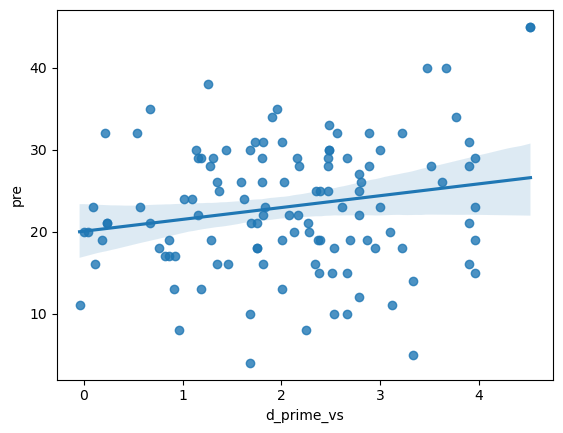

In [10]:
sns.regplot(data=speech_nb, x = "d_prime_vs", y = "pre")
y = speech_nb.pre
X = sm.add_constant(speech_nb.d_prime_vs)
est = sm.OLS(y, X).fit()
print(est.summary())

#### Correlation between learning and N-back scores

**fig 3. Auditory N-back and learning across both feedback conditions**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.189
Date:                Mon, 06 Jan 2025   Prob (F-statistic):             0.0429
Time:                        10:19:08   Log-Likelihood:                -421.23
No. Observations:                 119   AIC:                             846.5
Df Residuals:                     117   BIC:                             852.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.9488      2.194      2.255      

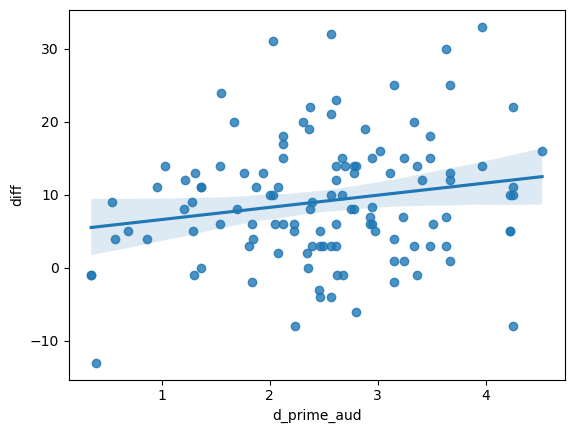

In [11]:
sns.regplot(data=speech_nb, x = "d_prime_aud", y = "diff")
y = speech_nb['diff']
X = sm.add_constant(speech_nb.d_prime_aud)
est = sm.OLS(y, X).fit()
print(est.summary())

**fig 4. Visuospatial N-back and learning across both feedback conditions**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.745
Date:                Mon, 06 Jan 2025   Prob (F-statistic):              0.100
Time:                        10:19:08   Log-Likelihood:                -421.94
No. Observations:                 119   AIC:                             847.9
Df Residuals:                     117   BIC:                             853.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6466      1.700      3.909      0.0

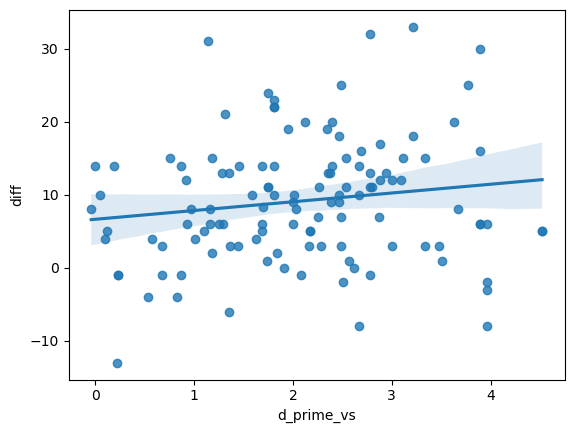

In [12]:
sns.regplot(data=speech_nb, x = "d_prime_vs", y = "diff")
y = speech_nb['diff']
X = sm.add_constant(speech_nb.d_prime_vs)
est = sm.OLS(y, X).fit()
print(est.summary())

#### Correlation between learning from different types of feedback and N-back scores

**fig 5. Auditory 2-back and learning from auditory feedback only**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8550
Date:                Thu, 30 Jan 2025   Prob (F-statistic):              0.359
Time:                        12:05:45   Log-Likelihood:                -193.22
No. Observations:                  60   AIC:                             390.4
Df Residuals:                      58   BIC:                             394.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.0033      2.716      0.738      

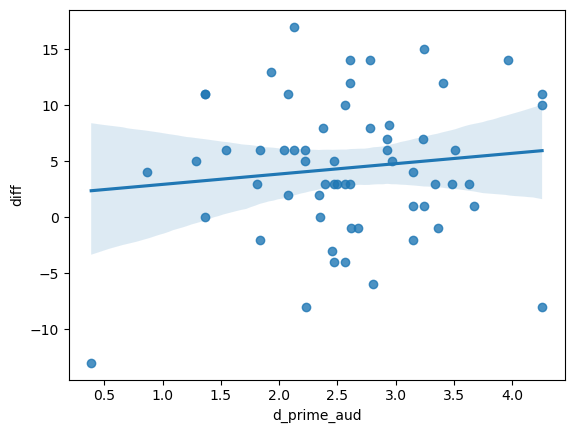

In [11]:
speech_nb_A = speech_nb[speech_nb.feedback == "A"]
sns.regplot(data=speech_nb_A, x = "d_prime_aud", y = "diff")
y = speech_nb_A['diff']
X = sm.add_constant(speech_nb_A.d_prime_aud)
est = sm.OLS(y, X).fit()
print(est.summary())

**fig 6. Visuospatial 2-back and learning from auditory feedback only**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.01063
Date:                Mon, 06 Jan 2025   Prob (F-statistic):              0.918
Time:                        10:19:09   Log-Likelihood:                -193.65
No. Observations:                  60   AIC:                             391.3
Df Residuals:                      58   BIC:                             395.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2451      1.741      2.438      0.0

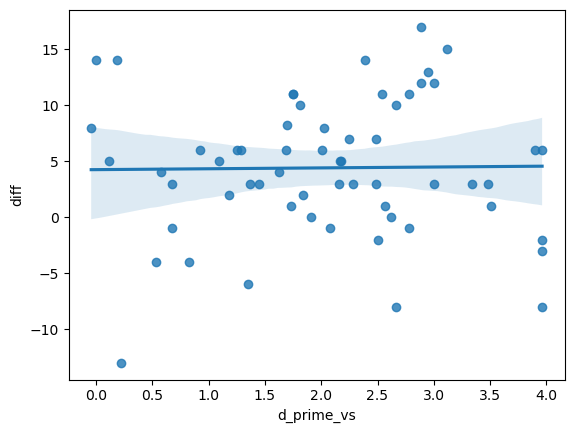

In [14]:
sns.regplot(data=speech_nb_A, x = "d_prime_vs", y = "diff")
y = speech_nb_A['diff']
X = sm.add_constant(speech_nb_A.d_prime_vs)
est = sm.OLS(y, X).fit()
print(est.summary())

**fig 7. Auditory 2-back and learning from orthographic feedback**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     9.165
Date:                Thu, 30 Jan 2025   Prob (F-statistic):            0.00370
Time:                        12:11:44   Log-Likelihood:                -200.64
No. Observations:                  59   AIC:                             405.3
Df Residuals:                      57   BIC:                             409.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3502      2.392      3.072      

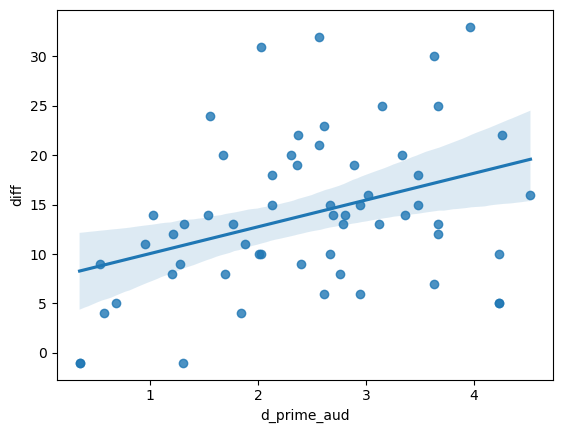

In [22]:
speech_nb_O = speech_nb[speech_nb.feedback == "O"]
sns.regplot(data=speech_nb_O, x = "d_prime_aud", y = "diff")
y = speech_nb_O['diff']
X = sm.add_constant(speech_nb_O.d_prime_aud)
est = sm.OLS(y, X).fit()
print(est.summary())

**fig 8. Visuospatial 2-back and learning from orthographic feedback**

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.526
Date:                Mon, 06 Jan 2025   Prob (F-statistic):             0.0377
Time:                        10:19:10   Log-Likelihood:                -202.78
No. Observations:                  59   AIC:                             409.6
Df Residuals:                      57   BIC:                             413.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7928      2.207      4.436      0.0

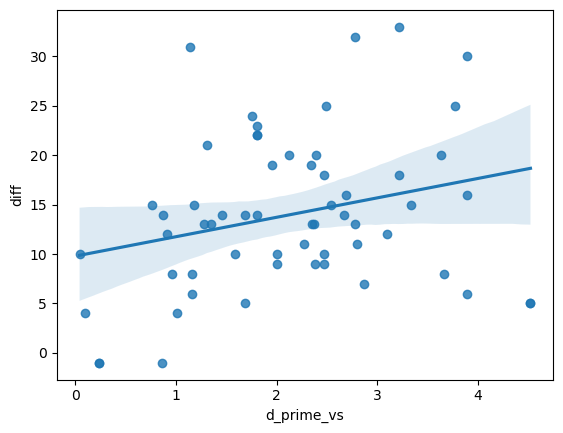

In [16]:
sns.regplot(data=speech_nb_O, x = "d_prime_vs", y = "diff")
y = speech_nb_O['diff']
X = sm.add_constant(speech_nb_O.d_prime_vs)
est = sm.OLS(y, X).fit()
print(est.summary())

## 2. More meaningful plots

**fig 9. Combined plot**

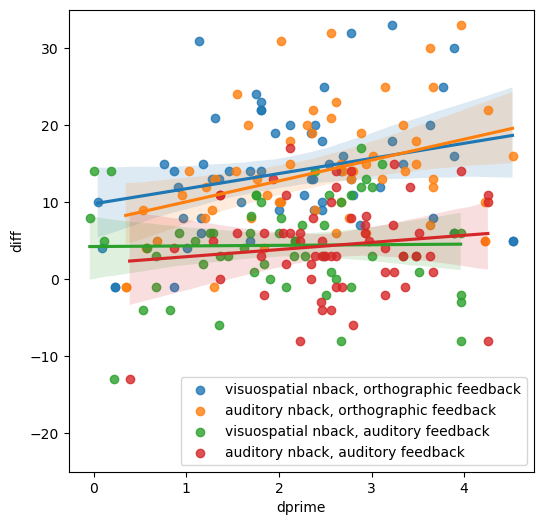

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x='d_prime_vs', y='diff', data=speech_nb_O, fit_reg=True, ax=ax, label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=speech_nb_O, fit_reg=True, ax=ax, label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=speech_nb_A, fit_reg=True, ax=ax, label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=speech_nb_A, fit_reg=True, ax=ax, label='auditory nback, auditory feedback')
ax.set(ylabel='diff', xlabel='dprime')
ax.set_ylim([-25, 35])
ax.legend()
plt.show()

In [27]:
speech_ancova = speech_nb_O.copy()
speech_ancova = speech_ancova.rename(columns = {'d_prime_aud': 'a', 'd_prime_vs': 'vs'})
speech_ancova = pd.melt(speech_ancova, id_vars=['sub', 'feedback', 'diff'], value_vars=['a', 'vs'], var_name='d_prime', value_name='nb')

array(['O'], dtype=object)

In [ ]:
ancova(data=data, dv='test_score', covar='current_grade', between='feedback')

**fig 10. Exclude subjects with no learning**

In [34]:
learning_only = speech_nb[speech_nb['diff'] > 0]
speech_nb[speech_nb['diff'] < 0] # show excluded subjects

,sub,test,ID,feedback,percent_correct,post,pre,diff,hit_rate_aud,fa_rate_aud,d_prime_aud,hit_rate_vs,fa_rate_vs,d_prime_vs
10,12,pre,True,O,19.0,18.0,19.0,-1.0,0.766667,0.283333,1.300881,0.666667,0.333333,0.861455
11,13,pre,True,A,35.0,34.0,35.0,-1.0,0.800000,0.033333,2.675536,0.433333,0.200000,0.673727
13,15,pre,True,A,15.0,13.0,15.0,-2.0,0.766667,0.133333,1.838685,0.966667,0.250000,2.508404
16,19,pre,True,A,19.0,11.0,19.0,-8.0,0.766667,0.066667,2.228999,0.966667,0.016667,3.961960
24,27,pre,True,A,15.0,13.0,15.0,-2.0,0.933333,0.050000,3.145940,0.966667,0.016667,3.961960
26,29,pre,True,A,27.0,26.0,27.0,-1.0,0.833333,0.008333,3.361401,0.900000,0.066667,2.782638
40,43,pre,True,A,22.0,21.0,22.0,-1.0,0.966667,0.216667,2.617415,0.866667,0.166667,2.078193
45,49,pre,True,A,29.0,21.0,29.0,-8.0,0.983333,0.016667,4.256090,0.900000,0.083333,2.664546
61,65,pre,True,A,32.0,19.0,32.0,-13.0,0.366667,0.233333,0.387218,0.433333,0.350000,0.217426
63,67,pre,True,A,29.0,26.0,29.0,-3.0,0.966667,0.266667,2.456840,0.983333,0.033333,3.961960


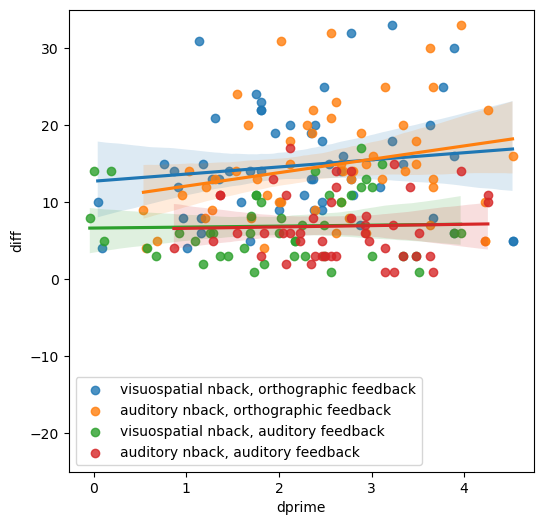

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
learning_O = learning_only[learning_only.feedback == "O"]
learning_A = learning_only[learning_only.feedback == "A"]
sns.regplot(x='d_prime_vs', y='diff', data=learning_O, fit_reg=True, ax=ax, label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=learning_O, fit_reg=True, ax=ax, label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=learning_A, fit_reg=True, ax=ax, label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=learning_A, fit_reg=True, ax=ax, label='auditory nback, auditory feedback')
ax.set(ylabel='diff', xlabel='dprime')
ax.set_ylim([-25, 35])
ax.legend()
plt.show()

**fig 11. Plot by high vs low pretest scores**

In [62]:
med = np.median(speech_nb['diff'])
speech_nb['high_pretest'] = speech_nb['diff'] > med

/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_3129/1325699144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  learning_only['high_pretest'] = learning_only['diff'] > med


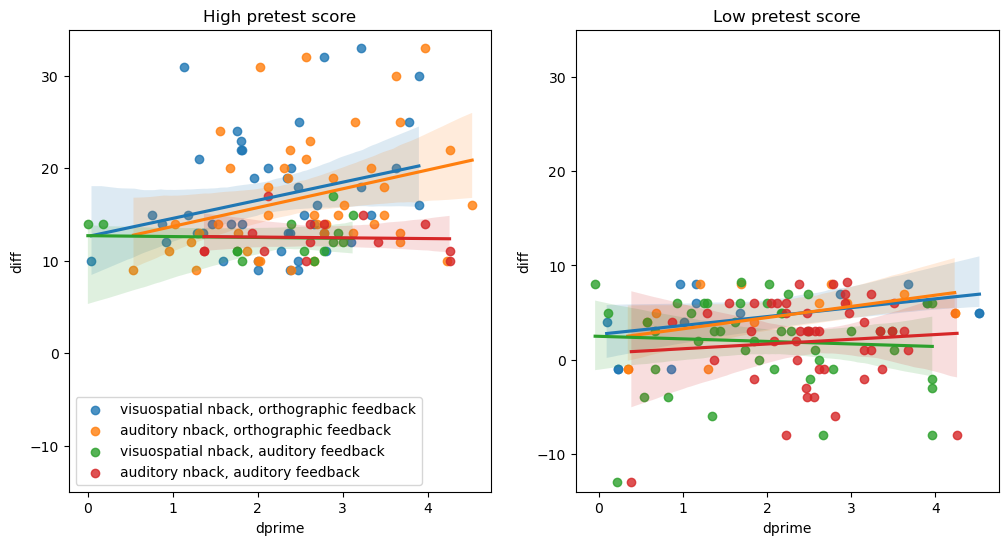

In [64]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
pretest_high = speech_nb[speech_nb.high_pretest == True]
pretest_high_O = pretest_high[pretest_high.feedback == "O"]
pretest_high_A = pretest_high[pretest_high.feedback == "A"]
sns.regplot(x='d_prime_vs', y='diff', data=pretest_high_O, fit_reg=True, ax=ax[0], label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_high_O, fit_reg=True, ax=ax[0], label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=pretest_high_A, fit_reg=True, ax=ax[0], label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_high_A, fit_reg=True, ax=ax[0], label='auditory nback, auditory feedback')
ax[0].set(ylabel='diff', xlabel='dprime')
ax[0].legend()
ax[0].set_ylim([-15, 35])
ax[0].set_title('High pretest score')

pretest_low = speech_nb[speech_nb.high_pretest == False]
pretest_low_O = pretest_low[pretest_low.feedback == "O"]
pretest_low_A = pretest_low[pretest_low.feedback == "A"]
sns.regplot(x='d_prime_vs', y='diff', data=pretest_low_O, fit_reg=True, ax=ax[1], label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_low_O, fit_reg=True, ax=ax[1], label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=pretest_low_A, fit_reg=True, ax=ax[1], label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_low_A, fit_reg=True, ax=ax[1], label='auditory nback, auditory feedback')
ax[1].set(ylabel='diff', xlabel='dprime')
ax[1].set_ylim([-14, 35])
ax[1].set_title('Low pretest score')

plt.show()

**fig 12. High vs low pretest scores, dropping subjects with no learning**

In [65]:
med = np.median(learning_only['diff'])
learning_only['high_pretest'] = learning_only['diff'] > med

/var/folders/bk/d0152l256wj91ds4hp514cj40000gn/T/ipykernel_3129/1458090646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  learning_only['high_pretest'] = learning_only['diff'] > med


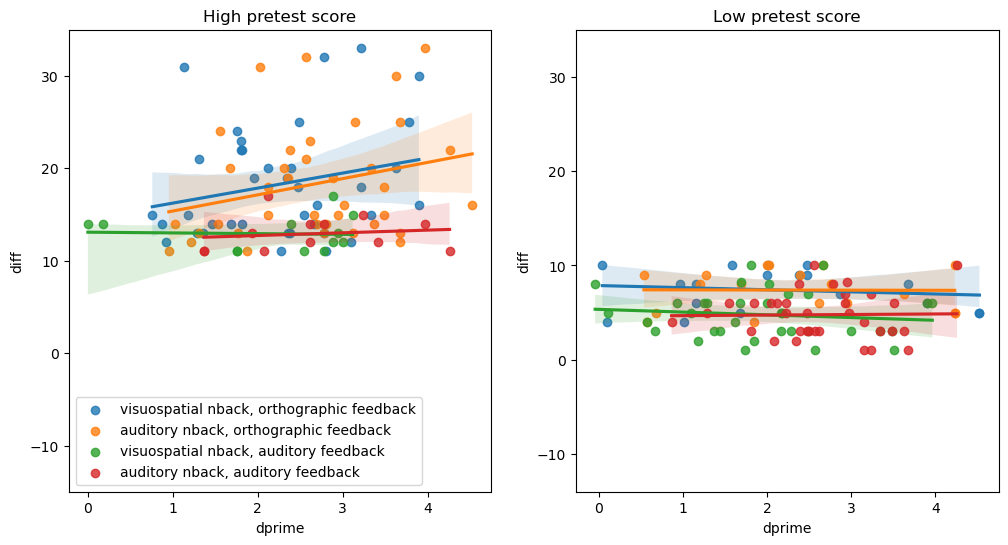

In [66]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
pretest_high = learning_only[learning_only.high_pretest == True]
pretest_high_O = pretest_high[pretest_high.feedback == "O"]
pretest_high_A = pretest_high[pretest_high.feedback == "A"]
sns.regplot(x='d_prime_vs', y='diff', data=pretest_high_O, fit_reg=True, ax=ax[0], label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_high_O, fit_reg=True, ax=ax[0], label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=pretest_high_A, fit_reg=True, ax=ax[0], label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_high_A, fit_reg=True, ax=ax[0], label='auditory nback, auditory feedback')
ax[0].set(ylabel='diff', xlabel='dprime')
ax[0].legend()
ax[0].set_ylim([-15, 35])
ax[0].set_title('High pretest score')

pretest_low = learning_only[learning_only.high_pretest == False]
pretest_low_O = pretest_low[pretest_low.feedback == "O"]
pretest_low_A = pretest_low[pretest_low.feedback == "A"]
sns.regplot(x='d_prime_vs', y='diff', data=pretest_low_O, fit_reg=True, ax=ax[1], label='visuospatial nback, orthographic feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_low_O, fit_reg=True, ax=ax[1], label='auditory nback, orthographic feedback')
sns.regplot(x='d_prime_vs', y='diff', data=pretest_low_A, fit_reg=True, ax=ax[1], label='visuospatial nback, auditory feedback')
sns.regplot(x='d_prime_aud', y='diff', data=pretest_low_A, fit_reg=True, ax=ax[1], label='auditory nback, auditory feedback')
ax[1].set(ylabel='diff', xlabel='dprime')
ax[1].set_ylim([-14, 35])
ax[1].set_title('Low pretest score')

plt.show()